# Comparative study: PySpark vs Pandas vs Polars
This assessment corresponds to the challenge proposed for the module 8 "Scalable data processing".

José Luis Puente Bodoque.

Monday, April 3, 2023.

## Table of contents

- [Approach of the assessment](#Approach-of-the-assessment)
- [Configuration of my test computer](#Configuration-of-my-test-computer)
- [Packages to use](#Packages-to-use)
- [How do I measure time executions?](#How-do-I-measure-time-executions?)
- [Measurements](#Measurements)
- [Function to plot the measurements](#Function-to-plot-the-measurements)
- [Issues I have run into during tests](#Issues-I-have-run-into-during-tests)
  * [Java heap runs out of memory](#Java-heap-runs-out-of-memory)
- [Load of CSV input files into DataFrame objects for each API](#Load-of-CSV-input-files-into-DataFrame-objects-for-each-API)
- [Measurements of times](#Measurements-of-times)
  * [Measurement 1: functions of aggregation](#Measurement-1:-functions-of-aggregation)
- [Measurement 2: filtering](#Measurement-2:-filtering)
- [Results](#Results)
- [Stop SparkSession object](#Stop-SparkSession-object)
- [Conclusions](#Conclusions)

## Approach of the assessment
This study is a simple and cualitative comparative of performance by using PySpark, Pandas and Polars Python libraries on a small, medium and large dataset. The measurement of performance actually consists of measuring how long these libraries take to run a block of operations over a DataFrame object. The operations to measure are two: (1) a series of a group by + count + sort functions of aggregations and (2) a filter operations. Both are common operations on tabular data.

In general, Spark is designed to scale large datasets that cannot fit into memory on a single machine. Spark uses distributed processing to parallelize computation across a cluster of machines, which can be more efficient than running on a single machine with limited resources. However, theoretically the overhead of distributing and coordinating the computation on a single machine can add additional latency, which can make PySpark slower even for larger datasets. So the real approach of this assessment is to check experimentally whether the previous statement is true or false.

On the other hand, Pandas and Polars are designed for in-memory processing on a single machine, which can be more efficient for smaller datasets that can fit into memory. Since they do not have the overhead of distributed processing, they should be faster for certain operations on smaller datasets. So we expect theretically better results even on larger datasets.

## Configuration of my test computer
I will run the tests on my personal laptop, which I'm using to course the master.

In [1]:
def print_pc_info():

    print('Computer information:\n'
          '· OS: Windows 11 Pro\n'
          '· Processor: Intel i5-11400H @ 2.70GHz\n'
          '· Cores: 6\n'
          '· Threads: 12\n'
          '· RAM: 16 GB\n'
          '· Java 11\n'
          '· Spark 3.3.2\n'
          '· Python 3.7.16\n'
          'I use 6 cores in this assessment.')

print_pc_info()

Computer information:
· OS: Windows 11 Pro
· Processor: Intel i5-11400H @ 2.70GHz
· Cores: 6
· Threads: 12
· RAM: 16 GB
· Java 11
· Spark 3.3.2
· Python 3.7.16
I use 6 cores in this assessment.


I will use all the cores it offers to me.

## Packages to use
The packages that I have used in the code are:

In [2]:
from pyspark import SparkConf
from pyspark.sql import SparkSession, functions
from matplotlib import pyplot as plt
import pandas as pd
import polars as pl
import time

- `pyspark`:  interface for Apache Spark in Python
  * `pyspark.sql`: provides the classes `SparkSession`, the entry point to programming Spark with the DataFrame API, and `functions`, which provides lots of methods to work on DatFrame, e.g. manipulating columns of a dataframe
- `matplotlib.pyplot`: to plot the comparative bar plots among the three libraries
- `pandas` and `polars`: are the two other libraries to compare each other. I had already installed `pandas` on my Anaconda base environment, but I had to installed `polars` by running `pip install polars` into my "spark332" virtual environment.
- `time` is the basic library that I will use to measure the time

In the next section I am explaining how I am going to measure executions times of the block of codes corresponding to the operations on DataFrame objects for each library of dataframes.

## How do I measure time executions?
To measure times I have used decorators in Python. Check out the definition below:

In [3]:
def measure_time(parameter_function):
    def wrapper_function(*args):
        # Store start time
        t_start = time.time()

        # Run the parameter function. Returns nothing
        parameter_function(*args)

        # Store end time and computes elapsed time
        t_end = time.time()
        t = t_end - t_start

        # Returns elapsed time
        return t

    return wrapper_function

The decorator function `measure_time` receives as parameter `parameter_function`, which performs the operation on the dataframe. `wrapper_function` actually receives as parameter `*args` the dataframe that `parameter_functions(*args)` will receive in turn. The most important thing is the code that *sandwiches* the parameter function: I am storing the time before and after running the operation. At the end I substract both times to obtain the elapsed time and I return it. So, if I tag each of functions with this decorator, the functions will return the measurement that I need to compare the APIs on a bar plot.

## Measurements
For naming the functions I has followed this standard: `compute_time_x_y_x(dataframe)`, where *x* may be either *agg* (aggregation functions) or *filter* (filter operation), *y* may be *small* for the smallest dataset, *medium* for the medium one or *large* for the largest one, and *y* refers to the DataFrame API *spark*, *pandas* or *polars*. Parameter `dataframe` is the DataFrame object in each of the APIs.

So the list of definitions are below:

In [4]:
@measure_time
def compute_time_agg_small_spark(dataframe):
    dataframe \
        .groupBy('Actor 1') \
        .agg(functions.count("*")) \
        .withColumnRenamed('count(1)', 'count') \
        .sort(functions.desc('count')) \
        .show()


@measure_time
def compute_time_agg_small_pandas(dataframe):
    # Group by 'Actor 1', get the count of each group and rename the column as 'Count'
    grouped_dataframe = dataframe.groupby('Actor 1').size().reset_index(name='Count')

    # Sort the DataFrame by the 'Count' column in descending order
    sorted_dataframe = grouped_dataframe.sort_values(by=['Count'], ascending=False)

    print(sorted_dataframe)


@measure_time
def compute_time_agg_small_polars(dataframe):
    grouped_df = (dataframe
                  .groupby('Actor 1')
                  .agg(pl.count('Actor 1').alias('Count'))
                  .sort('Count', descending=True)
                  )

    print(grouped_df)


@measure_time
def compute_time_agg_medium_spark(dataframe):
    dataframe \
        .groupBy('Incident Day of Week') \
        .agg(functions.count("*")) \
        .withColumnRenamed('count(1)', 'count') \
        .sort(functions.desc('count')) \
        .show()


@measure_time
def compute_time_agg_medium_pandas(dataframe):
    # Group by 'Incident Day of Week', get the size of each group, rename the index to 'count'
    grouped_df = dataframe.groupby('Incident Day of Week').size().reset_index(name='count')

    # Sort the DataFrame by the 'count' column in descending order
    sorted_df = grouped_df.sort_values(by=['count'], ascending=False)

    print(sorted_df)


@measure_time
def compute_time_agg_medium_polars(dataframe):
    grouped_df = (dataframe
                  .groupby('Incident Day of Week')
                  .agg(pl.count('Incident Day of Week').alias('count'))
                  .sort('count', descending=True)
                  )

    print(grouped_df)


@measure_time
def compute_time_agg_large_spark(dataframe):
    dataframe \
        .groupBy('Primary Type') \
        .agg(functions.count("*")) \
        .withColumnRenamed('count(1)', 'count') \
        .sort(functions.desc('count')) \
        .show()


@measure_time
def compute_time_agg_large_pandas(dataframe):
    # Group by 'Primary Type', get the count of each partition and rename the resulting column as 'count
    grouped_df = dataframe.groupby('Primary Type').size().reset_index(name='count')

    # Sort the DataFrame by the 'count' column in descending order
    sorted_df = grouped_df.sort_values(by=['count'], ascending=False)

    print(sorted_df)


@measure_time
def compute_time_agg_large_polars(dataframe):
    grouped_df = (dataframe
                  .groupby('Primary Type')
                  .agg(pl.count('Primary Type').alias('count'))
                  .sort('count', descending=True)
                  )

    print(grouped_df)


@measure_time
def compute_time_filter_small_spark(dataframe):
    dataframe.filter((functions.col('Release Year') < '2000')
                     & (functions.col('Director') == 'Steven Spielberg')
                     & (functions.col('Actor 1') == 'Harrison Ford')) \
        .show()


@measure_time
def compute_time_filter_small_pandas(dataframe):
    filtered_df = dataframe[(dataframe['Release Year'] < 2000) &
                            (dataframe['Director'] == 'Steven Spielberg') &
                            (dataframe['Actor 1'] == 'Harrison Ford')]

    print(filtered_df)


@measure_time
def compute_time_filter_small_polars(dataframe):
    filtered_df = dataframe.filter(
        (pl.col("Release Year") < 2000)
        & (pl.col("Director") == "Steven Spielberg")
        & (pl.col("Actor 1") == "Harrison Ford")
    )

    print(filtered_df)


@measure_time
def compute_time_filter_medium_spark(dataframe):
    dataframe.filter((functions.col('Incident Time') < '6:00:00')
                     & (functions.col('Incident Day of Week') == 'Saturday')
                     & (functions.col('Incident Category') == 'Fire Report')) \
        .show()


@measure_time
def compute_time_filter_medium_pandas(dataframe):
    filtered_df = dataframe[(dataframe['Incident Time'] < '6:00:00') &
                            (dataframe['Incident Day of Week'] == 'Saturday') &
                            (dataframe['Incident Category'] == 'Fire Report')]

    print(filtered_df)


@measure_time
def compute_time_filter_medium_polars(dataframe):
    filtered_df = dataframe.filter(
        (pl.col("Incident Time") < "6:00:00")
        & (pl.col("Incident Day of Week") == "Saturday")
        & (pl.col("Incident Category") == "Fire Report")
    )

    print(filtered_df)


@measure_time
def compute_time_filter_large_spark(dataframe):
    dataframe.filter((functions.col('Primary Type') == 'MOTOR VEHICLE THEFT')
                     & (functions.col('Location Description') == 'APARTMENT')
                     & (functions.col('Arrest') == 'true')) \
        .show()


@measure_time
def compute_time_filter_large_pandas(dataframe):
    filtered_df = dataframe[(dataframe['Primary Type'] == 'MOTOR VEHICLE THEFT') &
                            (dataframe['Location Description'] == 'APARTMENT') &
                            (dataframe['Arrest'] == True)]

    print(filtered_df)


@measure_time
def compute_time_filter_large_polars(dataframe):
    filtered_df = dataframe.filter((pl.col("Primary Type") == "MOTOR VEHICLE THEFT") &
                                   (pl.col("Location Description") == "APARTMENT") &
                                   (pl.col("Arrest") == "true"))

    print(filtered_df)

## Function to plot the measurements
I used the following function to compare, for each size of dataset and operation, the execution times by API.

In [5]:
def plot_times(x_labels, y_values, title):
    # Create a new figure object
    fig = plt.figure()

    # Plot the bar chart
    ax = fig.add_subplot(1, 1, 1)

    bar_colors = ('orange', 'green', 'blue')
    bars = ax.bar(x_labels, y_values, color=bar_colors)

    ax.set_xlabel('API')
    ax.set_ylabel('Execution time (s)')
    ax.set_title(title)

    formatted_values = ['{:.2f}'.format(value) for value in y_values]
    ax.bar_label(bars, labels=formatted_values, label_type='edge')

    plt.show()

## Issues I have run into during tests
### Java heap runs out of memory
The program returned me "java.lang.OutOfMemoryError: Java heap space error" when the Java Virtual Machine (JVM) ran out of memory in its heap space. The solution was to increase to 4 GB the memory cache by setting the `spark.executor.memory` and `spark.driver.memory` configuration properties.

- `spark.executor.memory` sets the amount of memory allocated for each executor
- `spark.driver.memory` sets the amount of memory allocated for the driver program

To set these properties in PySpark I did this:

In [6]:
spark_conf = SparkConf().setAppName("ComparativeStudy") \
    .set("spark.executor.memory", "4g") \
    .set("spark.driver.memory", "4g")

Next to the previous code I created a Spark session along with some setting related to spam messages:

In [7]:
spark_session = SparkSession.builder.config(conf=spark_conf).master("local[6]").getOrCreate()

logger = spark_session._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.WARN)

## Load of CSV input files into DataFrame objects for each API
To load the dataframes for Spark and Pandas I have created a specific function for each one.

In [8]:
def load_small_spark(spark_session, path_to_file, delimiter):
    return spark_session \
        .read \
        .options(header='true', inferschema='false') \
        .option("delimiter", delimiter) \
        .csv(path_to_file) \
        .persist()


def load_medium_spark(spark_session, path_to_file, delimiter):
    return spark_session \
        .read \
        .options(header='true', inferschema='false') \
        .option("delimiter", delimiter) \
        .csv(path_to_file) \
        .persist()


def load_large_spark(spark_session, path_to_file, delimiter):
    return spark_session \
        .read \
        .options(header='true', inferschema='false') \
        .option("delimiter", delimiter) \
        .csv(path_to_file) \
        .persist()


def load_small_pandas(path_to_file, delimiter):
    return pd.read_csv(path_to_file, delimiter=delimiter)


def load_medium_pandas(path_to_file, delimiter):
    return pd.read_csv(path_to_file, delimiter=delimiter)


def load_large_pandas(path_to_file, delimiter):
    return pd.read_csv(path_to_file, delimiter=delimiter)

For loading Polars dataframe I opted for doing it from Pandas dataframe. The load of data is shown below:

In [9]:
small_dataframe_spark = load_small_spark(spark_session, "data/films_san_francisco.csv", ",")
medium_dataframe_spark = load_medium_spark(spark_session, "data/crimes_san_francisco.csv", ",")
large_dataframe_spark = load_large_spark(spark_session, "data/crimes_chicago.csv", ",")

small_dataframe_pandas = load_small_pandas("data/films_san_francisco.csv", ",")
medium_dataframe_pandas = load_medium_pandas("data/crimes_san_francisco.csv", ",")
large_dataframe_pandas = load_large_pandas("data/crimes_chicago.csv", ",")

small_dataframe_polars = pl.from_pandas(small_dataframe_pandas)
medium_dataframe_polars = pl.from_pandas(medium_dataframe_pandas)
large_dataframe_polars = pl.from_pandas(large_dataframe_pandas)

## Measurements of times
### Measurement 1: functions of aggregation

In [10]:
elapsed_time_agg_small_spark = compute_time_agg_small_spark(small_dataframe_spark)
elapsed_time_agg_small_pandas = compute_time_agg_small_pandas(small_dataframe_pandas)
elapsed_time_agg_small_polars = compute_time_agg_small_polars(small_dataframe_polars)

elapsed_time_agg_medium_spark = compute_time_agg_medium_spark(medium_dataframe_spark)
elapsed_time_agg_medium_pandas = compute_time_agg_medium_pandas(medium_dataframe_pandas)
elapsed_time_agg_medium_polars = compute_time_agg_medium_polars(medium_dataframe_polars)

elapsed_time_agg_large_spark = compute_time_agg_large_spark(large_dataframe_spark)
elapsed_time_agg_large_pandas = compute_time_agg_large_pandas(large_dataframe_pandas)
elapsed_time_agg_large_polars = compute_time_agg_large_polars(large_dataframe_polars)

+--------------------+-----+
|             Actor 1|count|
+--------------------+-----+
|      Jonathan Groff|  125|
|         Hugh Laurie|  114|
|      Clint Eastwood|   78|
|          Taye Diggs|   58|
|                null|   52|
|       Jamie Clayton|   42|
|     Michael Douglas|   40|
|         Adam Devine|   39|
|           Tom Hardy|   37|
|        Jimmie Fails|   33|
|       Sonoya Mizuno|   32|
|        Keanu Reeves|   31|
|      Dwayne Johnson|   31|
|Arnold Schwarzene...|   31|
|      Cate Blanchett|   28|
|           Brian Cox|   28|
|     Craig Tsuyumine|   25|
|           Paul Rudd|   24|
|    Malcolm McDowell|   24|
|        Brit Marling|   23|
+--------------------+-----+
only showing top 20 rows

               Actor 1  Count
124     Jonathan Groff    125
95         Hugh Laurie    114
50      Clint Eastwood     80
222         Taye Diggs     58
106      Jamie Clayton     42
..                 ...    ...
110  Jennifer Connelly      1
109        Jenn Gotzon      1
107     

### Measurement 2: filtering

In [11]:
elapsed_time_filter_small_spark = compute_time_filter_small_spark(small_dataframe_spark)
elapsed_time_filter_small_pandas = compute_time_filter_small_pandas(small_dataframe_pandas)
elapsed_time_filter_small_polars = compute_time_filter_small_polars(small_dataframe_polars)

elapsed_time_filter_medium_spark = compute_time_filter_medium_spark(medium_dataframe_spark)
elapsed_time_filter_medium_pandas = compute_time_filter_medium_pandas(medium_dataframe_pandas)
elapsed_time_filter_medium_polars = compute_time_filter_medium_polars(medium_dataframe_polars)

elapsed_time_filter_large_spark = compute_time_filter_large_spark(large_dataframe_spark)
elapsed_time_filter_large_pandas = compute_time_filter_large_pandas(large_dataframe_pandas)
elapsed_time_filter_large_polars = compute_time_filter_large_polars(large_dataframe_polars)

+--------------------+------------+--------------------+--------------------+------------------+------------------+----------------+------------+-------------+------------+-------+
|               Title|Release Year|           Locations|           Fun Facts|Production Company|       Distributor|        Director|      Writer|      Actor 1|     Actor 2|Actor 3|
+--------------------+------------+--------------------+--------------------+------------------+------------------+----------------+------------+-------------+------------+-------+
|Indiana Jones and...|        1989|Administration Bu...|An artificial isl...|Paramount Pictures|Paramount Pictures|Steven Spielberg|Jeffrey Boam|Harrison Ford|Sean Connery|   null|
+--------------------+------------+--------------------+--------------------+------------------+------------------+----------------+------------+-------------+------------+-------+

                                  Title  Release Year  \
795  Indiana Jones and the Last Crusa

+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|      ID|Case Number|                Date|               Block|IUCR|       Primary Type|         Description|Location Description|Arrest|Domestic|Beat|District|Ward|Community Area|FBI Code|X Coordinate|Y Coordinate|Year|          Updated On|    Latitude|    Longitude|            Location|
+--------+-----------+--------------------+--------------------+----+-------------------+--------------------+--------------------+------+--------+----+--------+----+--------------+--------+------------+------------+----+--------------------+------------+-------------+--------------------+
|10260442|   HY447838|10/03/2015 01:00:...| 085XX S BUFFALO AVE|0910|MOTOR VEHICLE THEFT|          AUTOMOBILE|           APARTM

## Results

In [12]:
libraries = ('Spark', 'Pandas', 'Polars')
agg_small_times = (elapsed_time_agg_small_spark, elapsed_time_agg_small_pandas, elapsed_time_agg_small_polars)
agg_medium_times = (elapsed_time_agg_medium_spark, elapsed_time_agg_medium_pandas, elapsed_time_agg_medium_polars)
agg_large_times = (elapsed_time_agg_large_spark, elapsed_time_agg_large_pandas, elapsed_time_agg_large_polars)

filter_small_times = (
    elapsed_time_filter_small_spark, elapsed_time_filter_small_pandas, elapsed_time_filter_small_polars)
filter_medium_times = (
    elapsed_time_filter_medium_spark, elapsed_time_filter_medium_pandas, elapsed_time_filter_medium_polars)
filter_large_times = (
    elapsed_time_filter_large_spark, elapsed_time_filter_large_pandas, elapsed_time_filter_large_polars)

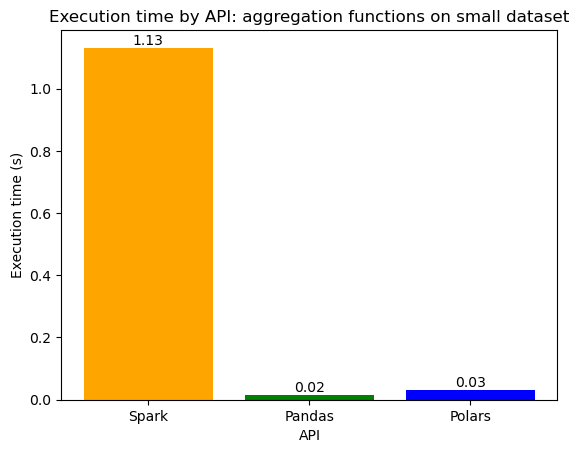

In [13]:
plot_times(libraries, agg_small_times,
               'Execution time by API: aggregation functions on small dataset')

Spark is notably slower than the others. No difference between Pandas and Polars.

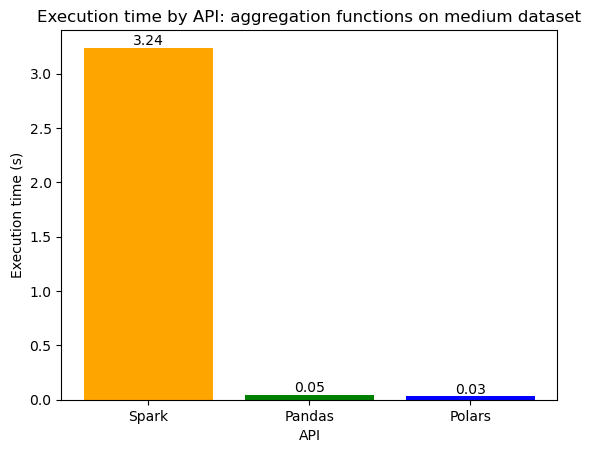

In [14]:
plot_times(libraries, agg_medium_times,
               'Execution time by API: aggregation functions on medium dataset')

The dataset size increases 664 times respecting to the small one and the time for Spark increases is triplied. However, Pandas times does not change for this increase of size.

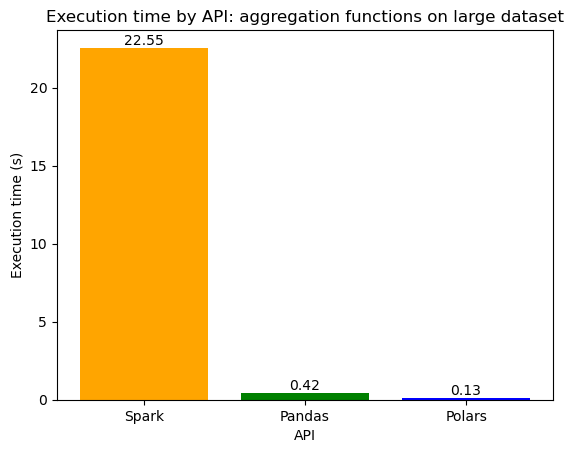

In [15]:
plot_times(libraries, agg_large_times,
               'Execution time by API: aggregation functions on large dataset')

The increase of time for Spark is exponential and unmeasured respecting the others libraries. Pandas and Polars times raises a little respecting the previous case and are pracatically the same among the two.

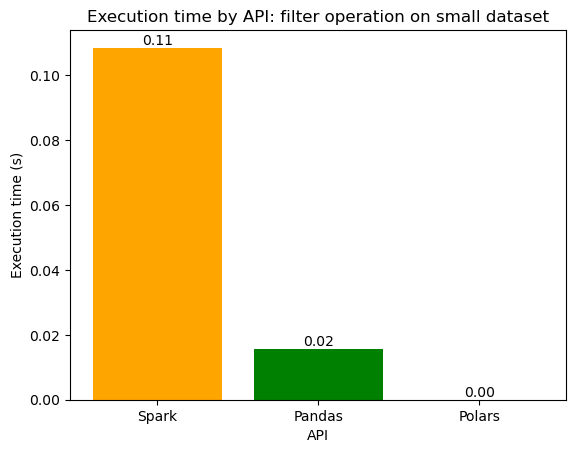

In [16]:
plot_times(libraries, filter_small_times,
               'Execution time by API: filter operation on small dataset')

Filter option is an operation significantly faster than functions aggregations. The time of Pandas and Polars are nearly zero and Spark takes slightly more time.

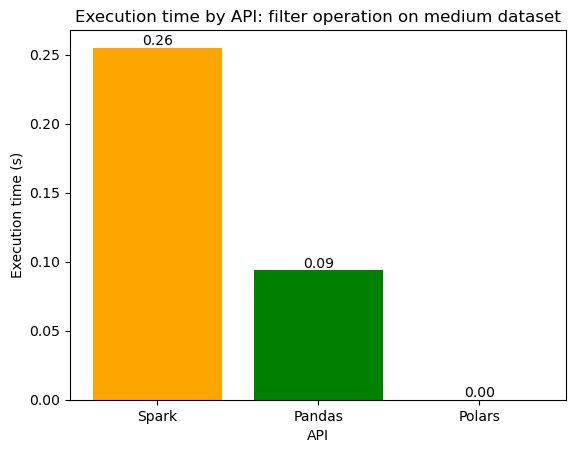

In [17]:
plot_times(libraries, filter_medium_times,
               'Execution time by API: filter operation on medium dataset')

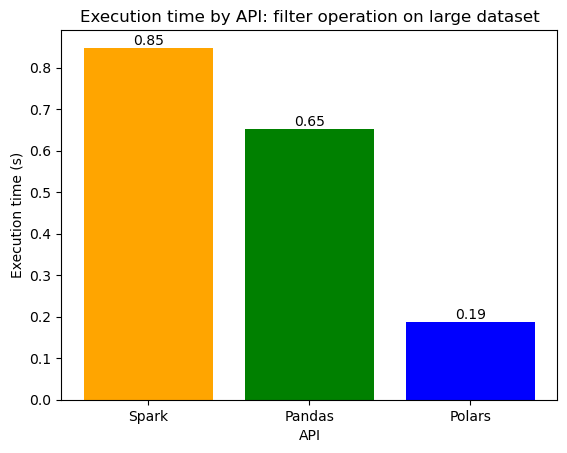

In [18]:
plot_times(libraries, filter_large_times,
               'Execution time by API: filter operation on large dataset')

## Stop SparkSession object
A good programming practise is to stop the SparkSession object by hand by calling `stop()` method.

In [19]:
spark_session.stop()  # release allocated resources

## Conclusions

The conclusions reached are the following:

- There is no significantly difference between Pandas and Polars on small and medium size dataset
- I only recommend first Polars and then Pandas when the dataset is extremely large and the number of operations is large, too
- The usage of Spark is not recommended on a single machine. Pandas or Polars are better alternatives by far for manipulating dataframes
- The performance of Spark, even on large dataset, is poor and its potential is wasted **on a single machine**. As I theorized at the beginning of this assessment when distributing and coordinating the computation on a single machine do add additional latency. Besides we might run the risk of increasing runtime scandalously and without an obvious cause